# Using RePP to Predict Pass Rusher Impact as Plays Develop
*RePP: **Re**current **P**ressure **P**robabilities*

**Jon Skaza & Matt Guthrie**

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
try:
  from google.colab import drive
  in_colab = True
except:
  in_colab = False
seed = 314 # for reproducibility, used in various places
np.random.seed(seed)

## Dataset Preprocessing

In [2]:
if in_colab:
  drive.mount("/content/drive")
  path = "/content/drive/MyDrive/nfl-big-data-bowl-2023"
else:
  path = os.environ.get("BIG_DATA_BOWL")

df = pd.read_csv(f"{path}/data/dataset.csv", index_col=0)
df.head()

Mounted at /content/drive


,game_id,play_id,nfl_id,speed,pressure,x,y,dist_from_qb,qb_in_tackle_box,n_blockers,...,speed_qb,x_qb,y_qb,x_ball,y_ball,quarter,down,yards_to_go,absolute_yardline_number,score_delta
1,2021090900,97,41263,0.96,1,1.74,-5.03,7.802083,1.0,5,...,0.35,-3.92,0.34,0.00,0.00,1,3,2,43.0,0
2,2021090900,97,41263,1.08,1,1.63,-5.01,7.766557,1.0,5,...,0.54,-4.00,0.34,-0.49,0.02,1,3,2,43.0,0
3,2021090900,97,41263,1.30,1,1.47,-4.99,7.695193,1.0,5,...,0.80,-4.09,0.33,-0.85,0.03,1,3,2,43.0,0
4,2021090900,97,41263,1.48,1,1.31,-4.94,7.603138,1.0,5,...,0.99,-4.18,0.32,-1.29,0.05,1,3,2,43.0,0
5,2021090900,97,41263,2.16,1,1.04,-4.83,7.404627,1.0,5,...,1.19,-4.29,0.31,-1.77,0.06,1,3,2,43.0,0


In [3]:
# examine missingness, models will need balanced sequences
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1077605 entries, 1 to 1077605
Data columns (total 30 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   game_id                   1077605 non-null  int64  
 1   play_id                   1077605 non-null  int64  
 2   nfl_id                    1077605 non-null  int64  
 3   speed                     1077605 non-null  float64
 4   pressure                  1077605 non-null  int64  
 5   x                         1077605 non-null  float64
 6   y                         1077605 non-null  float64
 7   dist_from_qb              1077605 non-null  float64
 8   qb_in_tackle_box          1077333 non-null  float64
 9   n_blockers                1077605 non-null  int64  
 10  x_C                       1077605 non-null  float64
 11  x_LT                      1077605 non-null  float64
 12  x_LG                      1077605 non-null  float64
 13  x_RG                      1

In [4]:
df.dropna(axis = 0, how = "any", inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1077203 entries, 1 to 1077605
Data columns (total 30 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   game_id                   1077203 non-null  int64  
 1   play_id                   1077203 non-null  int64  
 2   nfl_id                    1077203 non-null  int64  
 3   speed                     1077203 non-null  float64
 4   pressure                  1077203 non-null  int64  
 5   x                         1077203 non-null  float64
 6   y                         1077203 non-null  float64
 7   dist_from_qb              1077203 non-null  float64
 8   qb_in_tackle_box          1077203 non-null  float64
 9   n_blockers                1077203 non-null  int64  
 10  x_C                       1077203 non-null  float64
 11  x_LT                      1077203 non-null  float64
 12  x_LG                      1077203 non-null  float64
 13  x_RG                      1

In [9]:
def make_datasets(df: pd.DataFrame, group_by: list, feats: list, outcome: str, sequences: bool, 
samples: int, test_size: float, oversample = False):

  if oversample:
    ros = RandomOverSampler(random_state = seed)
    X = df[feats + group_by].to_numpy()
    y = df[outcome].to_numpy()
    X, y = ros.fit_resample(X, y) 
    y = y.reshape(y.shape[0], 1)
    df = pd.DataFrame(np.append(X, y, axis = 1),  columns = feats + group_by + [outcome])

  if sequences or samples > 0:
    X, y  = [], []
    grouped_df = df.groupby(group_by)
    for _, group_df in grouped_df:
      f = group_df[feats].to_numpy()
      if samples > 0:
        sub_seq_lens = np.random.randint(0, len(f), samples)
        sub_seq = [f[:n] for n in sub_seq_lens]
        X += sub_seq
      else: # sequences but no sampling
        X.append(group_df[feats].to_numpy())
      if sequences:
        if samples == 0:
          y.append(group_df[[outcome]].to_numpy()[0])
        else:
          for s in range(samples):
            y.append(group_df[[outcome]].to_numpy()[0])
      else: # no sequences but multiple samples
        y.append(np.repeat(group_df[outcome].values[0], sum(sub_seq_lens)))
    if sequences:
      X = tf.keras.utils.pad_sequences(X, dtype="float", padding="pre", value = -99)
      y = np.stack(y)
    else: # no sequences but multiple samples
      X = np.concatenate(X)
      y = np.concatenate(y).ravel()

  else:
      X = df[feats].to_numpy()
      y = df[outcome].to_numpy()
    
  return train_test_split(X, y, test_size = test_size, random_state = seed) + [outcome]

In [5]:
model_metrics = {}
def add_metrics(model, outcome_name: str, model_name: str, X_test: np.ndarray, y_test: np.ndarray):
    global model_metrics
    model_metrics[outcome_name] = {}
    y_pred = model.predict(X_test)
    if type(model) == LogisticRegression:
        y_score = model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score, pos_label = 1)
        roc = RocCurveDisplay(fpr = fpr, tpr = tpr)
        prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label= 1)
        pr = PrecisionRecallDisplay(precision=prec, recall=recall)
        auc = roc_auc_score(y_test, y_score)
        model_metrics[outcome_name][model_name] = {"auc": auc, "roc_curve": roc, "pr_curve": pr}
    else:
        evaluation = model.evaluate(X_test, y_test)
        auc = evaluation[1]
        acc = evaluation[2]
        model_metrics[outcome_name][model_name] = {"auc": auc, "acc": acc}
    print(f"Added metric for model {model_name} with outcome {outcome_name} to the model_metrics dictionary.")
    for k, v in model_metrics[outcome_name][model_name].items():
        print(f"{k}: {v}")

In [6]:
outcome = "pressure"
group_by = ["game_id", "play_id", "nfl_id"]
feats = [x for x in list(df.columns) if x not in group_by + [outcome]]

## ReSaP: **Re**current **Sa**ck **P**robabilities

### "Naive" Logistic Model

In [7]:
def model_logistic(data: list, max_iter: int):
    mod = LogisticRegression(max_iter = max_iter)
    mod.fit(data[0], data[2])
    add_metrics(mod, data[4], "logistic", data[1], data[3])
    return mod

In [10]:
data = make_datasets(df, group_by, feats, outcome, sequences = False, samples = 0, test_size = 0.2, oversample = True)
model_logistic(data, 1000)

Added metric for model logistic with outcome pressure to the model_metrics dictionary.
auc: 0.706911237074195
roc_curve: <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x7fd157b16130>
pr_curve: <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay object at 0x7fd1569cf640>


LogisticRegression(max_iter=1000)

In [11]:
data = make_datasets(df, group_by, feats, outcome, sequences = False, samples = 3, test_size = 0.2, oversample = True)
log_model = model_logistic(data, 1000)

Added metric for model logistic with outcome pressure to the model_metrics dictionary.
auc: 0.7553722134066272
roc_curve: <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x7fd1cb501fd0>
pr_curve: <sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay object at 0x7fd160412220>


### Probability Overlay animation

In [46]:
def make_probs(df, model, full_sequences, game_id, play_id, nfl_id):
  X, y  = [], []
  grouped_df = df[(df["game_id"]==game_id) & (df["play_id"]==play_id) & (df["nfl_id"]==nfl_id)].groupby(group_by)
  for _, group_df in grouped_df:
    f = group_df[feats].to_numpy()
    if full_sequences:
      sub_seq = [f[:n] for n in range(len(f))]
      X += sub_seq
    else:
      X = group_df[feats].to_numpy()

  return f, model.predict_proba(X)[:,1]

watt_rush , watt_probs = make_probs(df, log_model, False, 2021103103, 1984, 44842)
watt_probs

array([0.24261652, 0.23714769, 0.24060398, 0.25483592, 0.27676342,
       0.31116104, 0.34764437, 0.38266593, 0.42158423, 0.45363228,
       0.47551229, 0.49481092, 0.50277001, 0.51758393, 0.52268911,
       0.53430294, 0.55336181, 0.57919363, 0.61665482, 0.63937391,
       0.66031123, 0.68251752, 0.70323396, 0.71718901, 0.72750268,
       0.7363761 , 0.74382748, 0.74462043, 0.74596205, 0.74558629,
       0.75051471, 0.75144544, 0.75008504, 0.75267371, 0.75039345,
       0.74704426, 0.73497561, 0.72660833, 0.70949008, 0.68357854,
       0.65144602, 0.63064182, 0.59131038, 0.55895727, 0.54146499,
       0.5402896 , 0.550255  ])

In [51]:
# run this once
!apt install imagemagick

In [119]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation


plt.ioff()

# rush comparison animation 
lim_x = 10
lim_y = 10
plt.rcParams["figure.figsize"] = [0.75*lim_x, 0.75*lim_y]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
ax.set_xlim(-lim_x,lim_x)
ax.set_ylim(-lim_y,lim_y)
ax.set_facecolor('g')



line_rusher, = ax.plot([],[], 'orange')
line_qb, = ax.plot([],[], 'cyan')
line_ball, = ax.plot([],[], 'red')
los, = ax.plot([],[], 'w', lw=2)
label = ax.text(0, lim_y - (lim_y *0.1), "", ha='center', va='top', fontsize=12, bbox = (dict(facecolor='white', alpha=1)))

max_prob_frame = np.argmax(watt_probs)


def animate(i):
    los.set_data([0, 0], [-10, 10])
    
    # if i < np.argmax(watt_probs):
    #   text = 
    label.set_text(f'Pressure Probability: {int(watt_probs[i] * 100)}%\nMax Probability: {int(watt_probs[max_prob_frame] * 100)}% at Frame {max_prob_frame}')
    line_rusher.set_xdata(watt_rush[:i+1,1])
    line_rusher.set_ydata(watt_rush[:i+1,2])

    line_qb.set_xdata(watt_rush[:i+1,17])
    line_qb.set_ydata(watt_rush[:i+1,18])

    line_ball.set_xdata(watt_rush[:i+1,19])
    line_ball.set_ydata(watt_rush[:i+1,20])
         
ani = animation.FuncAnimation(fig, animate, frames=len(watt_rush))

ani.save('rush.gif',fps=10, writer = 'imagemagick')
plt.close(fig)

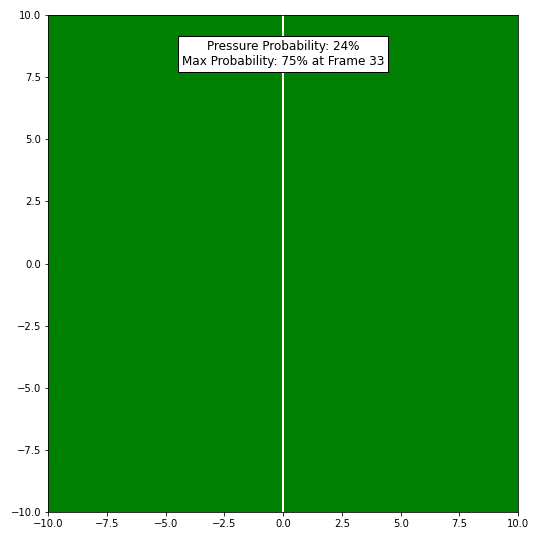

In [120]:
from IPython.display import Image
Image('rush.gif')

### LSTM

In [ ]:
def model_lstm(data: list, channels: int, num_epochs: int, val: float, folder: str):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
    mod = tf.keras.Sequential()
    mod.add(tf.keras.layers.Masking(mask_value= -99., input_shape= data[0].shape[1:]))
    mod.add(tf.keras.layers.LSTM(channels, input_shape = data[0].shape[1:]))
    mod.add(tf.keras.layers.Dense(data[2].shape[1], activation="sigmoid"))

    mod.compile(loss = "binary_crossentropy", optimizer="adam",
     metrics = [tf.keras.metrics.AUC(), tf.keras.metrics.BinaryAccuracy()])

    # callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)]

    mod.fit(data[0], data[2], epochs = num_epochs, validation_split = val)
    mod.save(folder)
    add_metrics(mod, data[4], "lstm", data[1], data[3])

In [ ]:
data = make_datasets(df, group_by, feats, outcome, sequences = True, samples = 0, test_size = 0.2, oversample = True)
model_lstm(data, 64, 20, 0.1, "full_seq")

773/773 [==============================] - 331s 421ms/step - loss: 0.3979 - auc_13: 0.6016 - binary_accuracy: 0.8482 - val_loss: 0.2687 - val_auc_13: 0.8760 - val_binary_accuracy: 0.8952


INFO:tensorflow:Assets written to: full_seq/assets


INFO:tensorflow:Assets written to: full_seq/assets


215/215 [==============================] - 18s 86ms/step - loss: 0.2796 - auc_13: 0.8706 - binary_accuracy: 0.8892
Added metric for model lstm with outcome pressure to the model_metrics dictionary.
auc: 0.8706457614898682
acc: 0.889212429523468


In [ ]:
data = make_datasets(df, group_by, feats, outcome, sequences = True, samples = 3, test_size = 0.2, oversample = True)
model_lstm(data, 64, 50, 0.1, "sub_seq")

In [ ]:
# train on full sequences
# test on subsequences
# X_train, _, y_train, _, _ = make_datasets(df, group_by, feats, outcome, sequences = True, samples = 0, test_size = 0.2, oversample = True)
# _, X_test, _, y_test, _ = make_datasets(df, group_by, feats, outcome, sequences = True, samples = 5, test_size = 0.2, oversample = True)
# data = [X_train, tf.keras.utils.pad_sequences(X_test, dtype="float", padding="pre", value = -99, maxlen = 193), X_test, y_train, y_test, "sensitivity"]
# model_lstm(data, 128, 50, 0.1)

### Transformer

In [ ]:
# def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
#     # Normalization and Attention
#     x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
#     x = tf.keras.layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
#     x = tf.keras.layers.Dropout(dropout)(x)
#     res = x + inputs

#     # Feed Forward Part
#     x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
#     x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
#     x = tf.keras.layers.Dropout(dropout)(x)
#     x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
#     return x + res

In [ ]:
# def build_model(
#     input_shape,
#     head_size,
#     num_heads,
#     ff_dim,
#     num_transformer_blocks,
#     mlp_units,
#     lstm_units,
#     dropout=0,
#     mlp_dropout=0,
# ):
#     inputs = tf.keras.Input(shape=input_shape)
#     x = inputs
#     x = tf.keras.layers.Masking(mask_value=-99.,input_shape= input_shape)(x)
#     x = tf.keras.layers.LSTM(lstm_units, input_shape = input_shape, return_sequences=True)(x)

#     for _ in range(num_transformer_blocks):
#         x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

#     x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_last")(x)
#     x = tf.keras.layers.Dropout(0.1)(x)
    
#     for dim in mlp_units:
#         x = tf.keras.layers.Dense(dim, activation="relu")(x)
#         x = tf.keras.layers.Dropout(mlp_dropout)(x)
    
#     outputs = tf.keras.layers.Dense(y.shape[1], activation="sigmoid")(x)
#     return tf.keras.Model(inputs, outputs)

In [ ]:
# outcomes = ["pff_sack", "havoc"]
# datasets = {}
# for o in outcomes:
#     group_by = ["game_id", "play_id", "nfl_id"]
#     outcome = [o]
#     feats = [x for x in list(df.columns) if x not in group_by + outcomes]

#     X, y = make_features(df, group_by, feats, outcome)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

#     weight_0 = (1 / sum(y_train == [0])) * (len(y_train) / 2.0)
#     weight_1 = (1 / sum(y_train == [1])) * (len(y_train) / 2.0)
#     class_weight = {0: weight_0, 1: weight_1}

#     num_epochs = 1
#     val = 0.2 

#     datasets[o] = {"X_train": X_train, "X_test": X_test,
#     "y_train": y_train, "y_test": y_test, "class_weight": class_weight,
#     "num_epochs": num_epochs, "val": val}

In [ ]:
# for k, v in datasets.items():
#     input_shape = v["X_train"].shape[1:]

#     model = build_model(
#         input_shape,
#         head_size=128,
#         num_heads=4,
#         ff_dim=4,
#         num_transformer_blocks=1,
#         mlp_units=[128],
#         mlp_dropout=0.2,
#         dropout=0.25,
#         lstm_units=32
#     )

#     model.compile(
#         loss="binary_crossentropy",
#         optimizer="adam",
#         #optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#         metrics = [tf.keras.metrics.AUC()]
#     )
#     #model.summary()

#     callbacks = [tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=3, restore_best_weights=True)]

#     model.fit(
#         v["X_train"],
#         v["y_train"],
#         validation_split=v["val"],
#         epochs=v["num_epochs"],
#         #batch_size=64,
#         callbacks=callbacks,
#         class_weight = v["class_weight"]
#     )

#     model.evaluate(v["X_test"], v["y_test"], verbose=1)